**SUPPLY CHAIN ENGINEERING PROJECT BY:**

**Shivie Saksenaa, Neha Patil & Sakshi Aggarwal**



**INSTALLATION OF GUROBIPY FOR OPRTIMIZATION**

In [ ]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 44.7 MB/s eta 0:00:00


In [ ]:
from gurobipy import Model, GRB, quicksum
import pandas as pd

# SETUP

plants = ["Frankfurt", "Mexico", "Gary", "Sunchem", "Canada", "Venezuela"]
years = list(range(1982, 1988)) #why we are using it
americas = ["Mexico", "Gary", "Canada", "Venezuela"]

# Local production cost per lb in 1982 (in local currency)
#frankfurt-DEM , Mexico-MXP, gary-USD, Sunchem- JPY, canda - CAD, Vnezuela- VEB
base_local_cost = {"Frankfurt": 1.85, "Mexico": 97, "Gary": 1.04,
                   "Sunchem": 320, "Canada": 1.20, "Venezuela": 4.8}

#Exchange rate in 1982 (local currency per USD)
#fixed prices from 1982-1988,
#it costs more pesosz(Mexico) to buy a USD, which makes local production cheaper in USD terms — if local inflation doesn't rise too fast.
# code for the graph:
fx_adjustment = {
    "Frankfurt": [2.38]*6,
    "Mexico": [96.5, 105, 115, 125, 135, 150],
    "Gary": [1]*6,
    "Sunchem": [235]*6,
    "Canada": [1.23]*6,
    "Venezuela": [4.3, 5.0, 6.0, 6.8, 7.5, 8.2]
}

# Inflation assumptions
#we have taken avg of 1982-1987 year
#This simulates real-world cost creep due to local economic pressure — which is essential in global network design.
#graph below (2)

inflation = {"Frankfurt": 0.03, "Mexico": 0.20, "Gary": 0.05,
             "Sunchem": 0.02, "Canada": 0.04, "Venezuela": 0.25}

# Tariffs by plant by year (as % of value)
#So this adds to the per-pound cost when exporting from that country.
#over 6 years

tariffs = {
    "Frankfurt": [0.095]*6,#tariffs remain same over the next 6 years
    "Mexico": [0.60, 0.55, 0.45, 0.35, 0.25, 0.15],
    #Incentivizes long-term investment, not short-term dominance
    #Declines yearly, simulating a NAFTA-style agreement in mexico (we can add this to the report, and highlight, it will show that we have researched)
    "Gary": [0]*6,#no export/import tarrif
    "Sunchem": [0.06]*6,
    "Canada": [0]*6, #in case study it is given like that
    "Venezuela": [0.50]*6 ##Combined with inflation, this makes Venezuela uncompetitive

}
# Transport cost ($/lb)
transport = {
    "Frankfurt": [0.12]*6,
    "Mexico": [0.10]*6,
    "Gary": [0.05]*6,
    "Sunchem": [0.14]*6,
    "Canada": [0.07]*6,
    "Venezuela": [0.13]*6
}

co2 = {"Frankfurt": 10, "Mexico": 20, "Gary": 30,
       "Sunchem": 15, "Canada": 18, "Venezuela": 35}

capacity = {"Frankfurt": 47, "Mexico": 22, "Gary": 18.5,
            "Sunchem": 5, "Canada": 3.7, "Venezuela": 4.5}

demand = {1982: 79.9, 1983: 82, 1984: 84, 1985: 85.5, 1986: 87, 1987: 88}

#In the UI, we can probably make this dynamic?
# PARAMETERS
co2_weight = 0.01
plant_open_penalty = 3.0  # Stronger penalty to force plant selection

#MODEL

m = Model("Applichem_Final_Model")
x = m.addVars(plants, years, name="Production", lb=0)
y = m.addVars(plants, years, vtype=GRB.BINARY, name="Active")

# USD cost per plant per year
usd_cost = {}
for p in plants:
    for i, t in enumerate(years):
        infl_factor = (1 + inflation[p]) ** i
        local_cost = base_local_cost[p] * infl_factor
        fx = fx_adjustment[p][i]
        base_usd = local_cost / fx
        tariff_usd = tariffs[p][i] * base_usd
        transport_usd = transport[p][i]
        total_usd = base_usd + tariff_usd + transport_usd
        usd_cost[p, t] = total_usd

# Objective: Total cost + co2 + penalty
m.setObjective(
    quicksum(
        usd_cost[p, t] * x[p, t] +
        co2_weight * co2[p] * x[p, t] +
        plant_open_penalty * y[p, t]
        for p in plants for t in years
    ),
    GRB.MINIMIZE
)

# CONSTRAINTS

for t in years:
    m.addConstr(quicksum(x[p, t] for p in plants) == demand[t], name=f"demand_{t}")
    m.addConstr(quicksum(y[p, t] for p in plants) >= 2, name=f"min_plants_{t}")
    m.addConstr(quicksum(y[p, t] for p in americas) >= 1, name=f"americas_{t}")
    for p in plants:
        m.addConstr(x[p, t] <= capacity[p] * y[p, t], name=f"cap_{p}_{t}")

m.optimize()

#OUTPUT

retained = {p for p in plants if any(y[p, t].X > 0.5 for t in years)}
closed = set(plants) - retained

print("\n📦 Retained Plants:")
for p in sorted(retained):
    print(f"✅ {p}")
print("\n🚫 Closed Plants:")
for p in sorted(closed):
    print(f"❌ {p}")

print(f"\n💰 Total Optimized Cost: ${m.ObjVal:.2f} million")

# Production Matrix
records = []
for t in years:
    for p in plants:
        q = x[p, t].X
        if q > 0.01:
            records.append([t, p, round(q, 2), round(usd_cost[p, t], 4), round(co2[p] * q, 2)])

df = pd.DataFrame(records, columns=["Year", "Plant", "Production (M lbs)", "Cost/lb (USD)", "CO2 Emissions"])
pivot = df.pivot(index="Year", columns="Plant", values="Production (M lbs)").fillna(0).round(2)

print("\n📊 Production Summary (M lbs):")
print(pivot)

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 54 rows, 72 columns and 168 nonzeros
Model fingerprint: 0x0310ea7e
Variable types: 36 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 857.8928254
Presolve removed 54 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 780.879 857.893 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.808785385821e+02, best b

**PLANT START UP COST ADDED: EG CANADA - LATER ON**

In [ ]:
from gurobipy import Model, GRB, quicksum
import pandas as pd

#SETUP

plants = ["Frankfurt", "Mexico", "Gary", "Sunchem", "Canada", "Venezuela"]
years = list(range(1982, 1988))
americas = ["Mexico", "Gary", "Canada", "Venezuela"]

base_local_cost = {"Frankfurt": 1.85, "Mexico": 97, "Gary": 1.04,
                   "Sunchem": 320, "Canada": 1.20, "Venezuela": 4.8}

fx_adjustment = {
    "Frankfurt": [2.38]*6,
    "Mexico": [96.5, 105, 115, 125, 135, 150],
    "Gary": [1]*6,
    "Sunchem": [235]*6,
    "Canada": [1.23]*6,
    "Venezuela": [4.3, 5.0, 6.0, 6.8, 7.5, 8.2]
}

inflation = {"Frankfurt": 0.03, "Mexico": 0.20, "Gary": 0.05,
             "Sunchem": 0.02, "Canada": 0.04, "Venezuela": 0.25}

tariffs = {
    "Frankfurt": [0.095]*6,
    "Mexico": [0.60, 0.55, 0.45, 0.35, 0.25, 0.15],
    "Gary": [0]*6,
    "Sunchem": [0.06]*6,
    "Canada": [0]*6,
    "Venezuela": [0.50]*6
}

transport = {
    "Frankfurt": [0.12]*6,
    "Mexico": [0.10]*6,
    "Gary": [0.05]*6,
    "Sunchem": [0.14]*6,
    "Canada": [0.07]*6,
    "Venezuela": [0.13]*6
}

co2 = {"Frankfurt": 10, "Mexico": 20, "Gary": 30,
       "Sunchem": 15, "Canada": 18, "Venezuela": 35}

capacity = {"Frankfurt": 47, "Mexico": 22, "Gary": 18.5,
            "Sunchem": 5, "Canada": 3.7, "Venezuela": 4.5}

demand = {1982: 79.9, 1983: 82, 1984: 84, 1985: 85.5, 1986: 87, 1987: 88}

# PARAMETERS
co2_weight = 0.01
plant_open_penalty = 3.0
startup_cost = 3.0  # One-time cost per plant if activated (3 million USD)

#MODEL

m = Model("Applichem_Startup_Cost_Model")
x = m.addVars(plants, years, name="Production", lb=0)
y = m.addVars(plants, years, vtype=GRB.BINARY, name="Active")
startup = m.addVars(plants, vtype=GRB.BINARY, name="Startup")

# USD cost per lb
usd_cost = {}
for p in plants:
    for i, t in enumerate(years):
        infl_factor = (1 + inflation[p]) ** i
        local_cost = base_local_cost[p] * infl_factor
        fx = fx_adjustment[p][i]
        base_usd = local_cost / fx
        tariff_usd = tariffs[p][i] * base_usd
        transport_usd = transport[p][i]
        usd_cost[p, t] = base_usd + tariff_usd + transport_usd

# Objective function: cost + CO2 + plant operation + one-time startup
m.setObjective(
    quicksum(
        usd_cost[p, t] * x[p, t] +
        co2_weight * co2[p] * x[p, t] +
        plant_open_penalty * y[p, t]
        for p in plants for t in years
    ) + quicksum(startup_cost * startup[p] for p in plants),
    GRB.MINIMIZE
)

#CONSTRAINTS

# Demand must be met
for t in years:
    m.addConstr(quicksum(x[p, t] for p in plants) == demand[t], name=f"demand_{t}")

# Capacity only when active
for p in plants:
    for t in years:
        m.addConstr(x[p, t] <= capacity[p] * y[p, t], name=f"cap_{p}_{t}")

# At least 2 plants must be active per year
for t in years:
    m.addConstr(quicksum(y[p, t] for p in plants) >= 2, name=f"min_plants_{t}")

# At least 1 plant in the Americas must be active
for t in years:
    m.addConstr(quicksum(y[p, t] for p in americas) >= 1, name=f"americas_{t}")

# Startup logic: if plant active in any year, startup = 1
for p in plants:
    for t in years:
        m.addConstr(startup[p] >= y[p, t], name=f"startup_trigger_{p}_{t}")

m.optimize()

#OUTPUT

retained = {p for p in plants if any(y[p, t].X > 0.5 for t in years)}
closed = set(plants) - retained

print("\n📦 Retained Plants:")
for p in sorted(retained):
    print(f"✅ {p}")
print("\n🚫 Closed Plants:")
for p in sorted(closed):
    print(f"❌ {p}")

print(f"\n💰 Total Optimized Cost (includes startup cost): ${m.ObjVal:.2f} million")

# Production matrix
records = []
for t in years:
    for p in plants:
        q = x[p, t].X
        if q > 0.01:
            records.append([t, p, round(q, 2), round(usd_cost[p, t], 4), round(co2[p] * q, 2)])

df = pd.DataFrame(records, columns=["Year", "Plant", "Production (M lbs)", "Cost/lb (USD)", "CO2 Emissions"])
pivot = df.pivot(index="Year", columns="Plant", values="Production (M lbs)").fillna(0).round(2)

print("\n📊 Production Summary (M lbs):")
print(pivot)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 90 rows, 78 columns and 240 nonzeros
Model fingerprint: 0x3ef6202d
Variable types: 36 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 891.2548703
Presolve removed 90 rows and 78 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 792.879 891.255 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.928785385821e+02, best bound 7.928785385821e+02, gap 0.0000%

📦 Retained Plants:
✅ Canada
✅ Fr

<ipython-input-5-60e18fc5a44d>:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


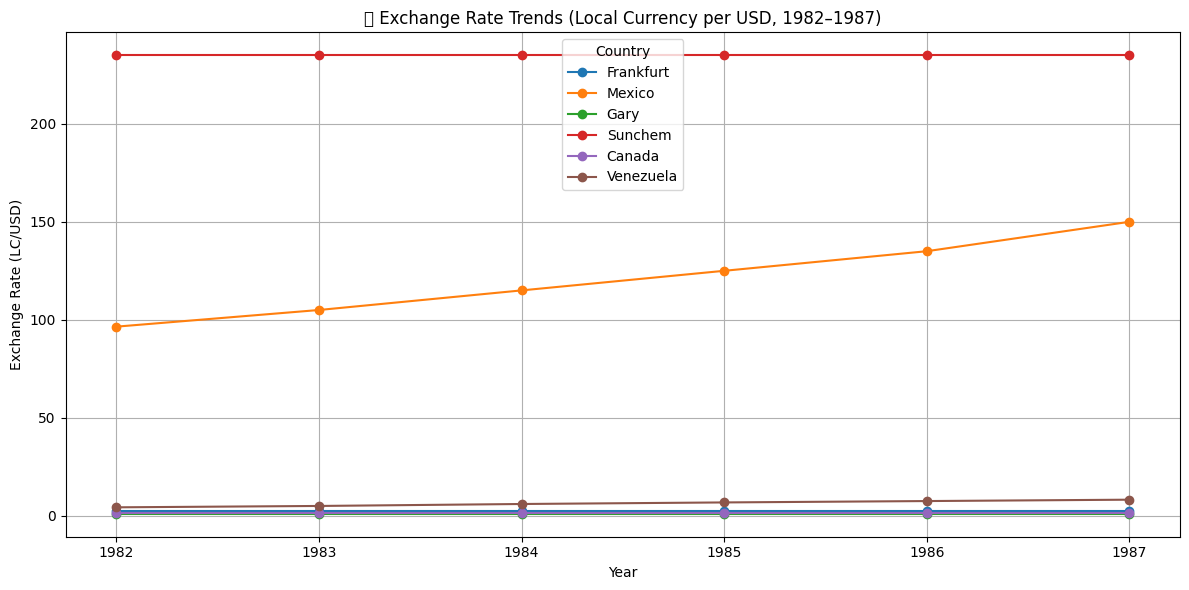

In [ ]:
import matplotlib.pyplot as plt

# Exchange rate data (local currency per USD)
fx_adjustment = {
    "Frankfurt": [2.38]*6,
    "Mexico": [96.5, 105, 115, 125, 135, 150],
    "Gary": [1]*6,
    "Sunchem": [235]*6,
    "Canada": [1.23]*6,
    "Venezuela": [4.3, 5.0, 6.0, 6.8, 7.5, 8.2]
}

years = list(range(1982, 1988))

# Plotting
plt.figure(figsize=(12, 6))
for country, fx in fx_adjustment.items():
    plt.plot(years, fx, marker='o', label=country)

plt.title("📈 Exchange Rate Trends (Local Currency per USD, 1982–1987)")
plt.xlabel("Year")
plt.ylabel("Exchange Rate (LC/USD)")
plt.legend(title="Country")
plt.grid(True)
plt.tight_layout()
plt.show()


What You’ll See:
Mexico and Venezuela with steep upward curves → depreciation

Germany, Canada, US, Japan stay relatively flat → stable currencies

This helps visually reinforce:

Why Mexico might become cheaper over time (unless inflation rises)

Why Venezuela’s risk of cost instability is high

Why Frankfurt and Gary provide FX-stable cost structures

<ipython-input-6-f9829c64626d>:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


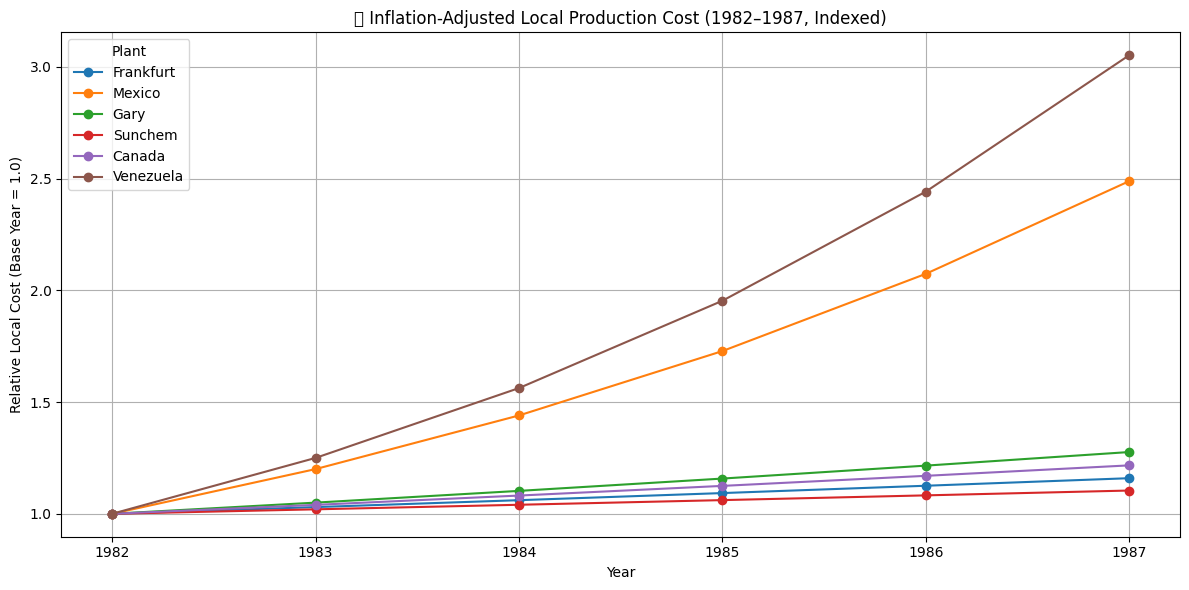

In [ ]:
import matplotlib.pyplot as plt

# Inflation rates by plant
inflation = {
    "Frankfurt": 0.03,
    "Mexico": 0.20,
    "Gary": 0.05,
    "Sunchem": 0.02,
    "Canada": 0.04,
    "Venezuela": 0.25
}

# Normalize base cost as 1.0
base_cost = 1
years = list(range(1982, 1988))

# Calculate inflation-adjusted cost
inflation_costs = {
    plant: [base_cost * ((1 + rate) ** i) for i in range(len(years))]
    for plant, rate in inflation.items()
}

# Plot
plt.figure(figsize=(12, 6))
for plant, costs in inflation_costs.items():
    plt.plot(years, costs, marker='o', label=plant)

plt.title("📈 Inflation-Adjusted Local Production Cost (1982–1987, Indexed)")
plt.xlabel("Year")
plt.ylabel("Relative Local Cost (Base Year = 1.0)")
plt.legend(title="Plant")
plt.grid(True)
plt.tight_layout()
plt.show()


Mexico and Venezuela show steep increases → inflation makes local production more expensive quickly

Frankfurt, Sunchem, Canada stay flatter → more stable economies

This directly affects USD cost in your supply chain model when combined with FX rates

<ipython-input-8-0cc55c1ff333>:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


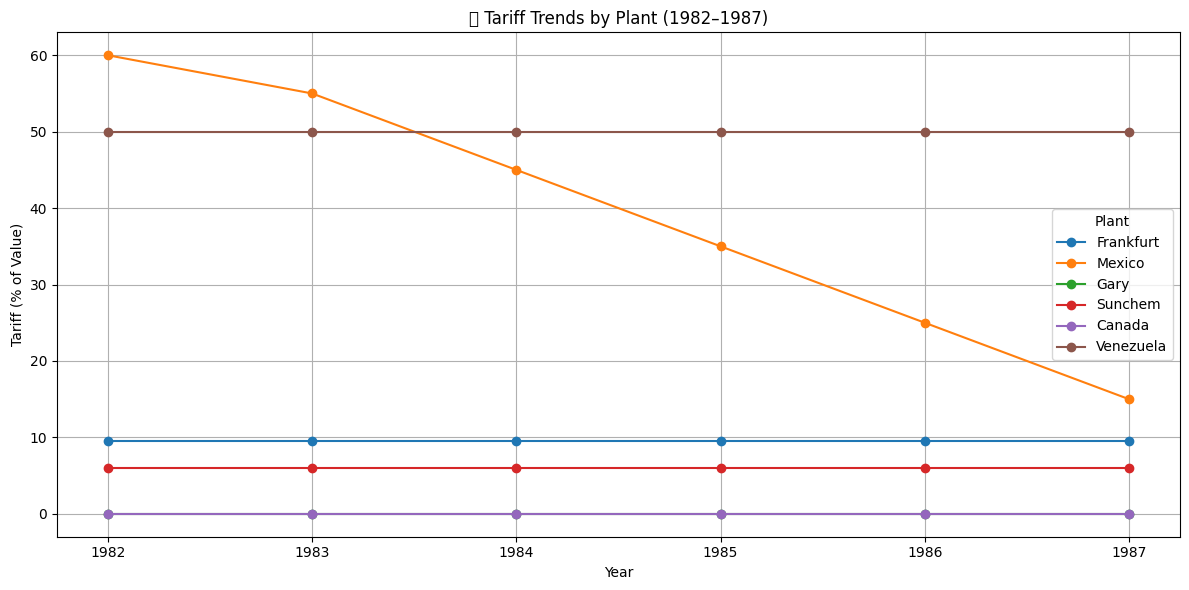

In [ ]:
import matplotlib.pyplot as plt

# Tariff data by plant (as % of value)
tariffs = {
    "Frankfurt": [0.095]*6,
    "Mexico": [0.60, 0.55, 0.45, 0.35, 0.25, 0.15],
    "Gary": [0]*6,
    "Sunchem": [0.06]*6,
    "Canada": [0]*6,
    "Venezuela": [0.50]*6
}

years = list(range(1982, 1988))  # 1982–1987

plt.figure(figsize=(12, 6))
for plant, values in tariffs.items():
    plt.plot(years, [v * 100 for v in values], marker='o', label=plant)  # Convert to %

plt.title("📉 Tariff Trends by Plant (1982–1987)")
plt.xlabel("Year")
plt.ylabel("Tariff (% of Value)")
plt.legend(title="Plant")
plt.grid(True)
plt.tight_layout()
plt.show()


Mexico’s line will slope downward — simulating improved trade policy (e.g. NAFTA trend)

Frankfurt, Sunchem, Venezuela have flat lines

Gary & Canada remain at 0% — indicating no export tariffs

This graph helps visualize why Mexico may gain cost competitiveness over time, while Venezuela remains unattractive.


<ipython-input-2-54bd1b553390>:25: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


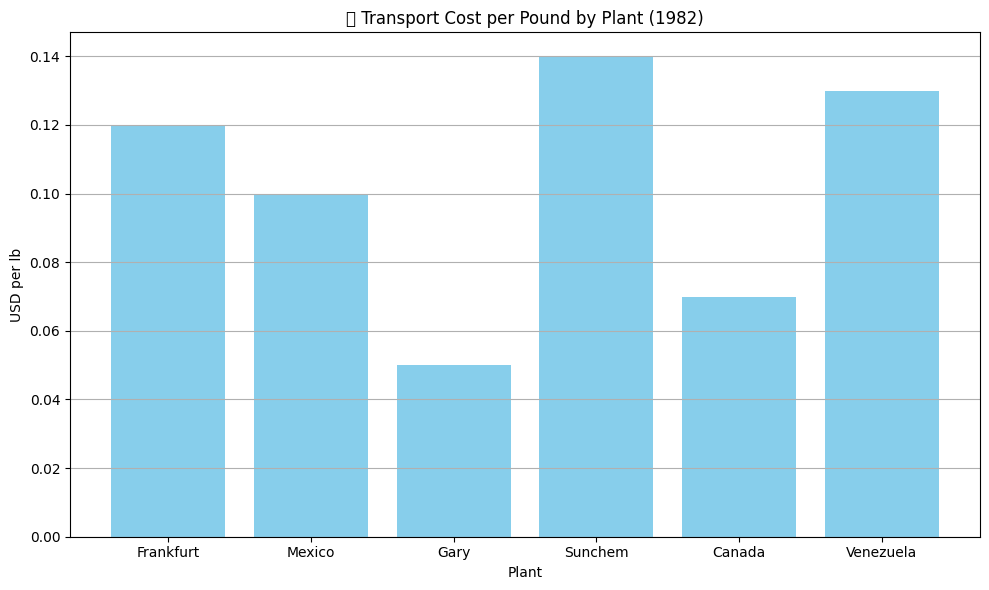

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Transport cost ($/lb)
transport = {
    "Frankfurt": [0.12]*6,
    "Mexico": [0.10]*6,
    "Gary": [0.05]*6,
    "Sunchem": [0.14]*6,
    "Canada": [0.07]*6,
    "Venezuela": [0.13]*6
}

# Years: 1982–1987
years = list(range(1982, 1988))

# ===== BAR CHART: Transport Costs (1982 only) =====
plt.figure(figsize=(10, 6))
transport_1982 = [transport[p][0] for p in transport]
plt.bar(transport.keys(), transport_1982, color='skyblue')
plt.title("🚚 Transport Cost per Pound by Plant (1982)")
plt.ylabel("USD per lb")
plt.xlabel("Plant")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



zThis lets you:

Compare cost evolution over time

Spot when Mexico overtakes Venezuela in cost

Justify plant shutdowns or investments

<ipython-input-5-f7687abeaa1e>:58: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


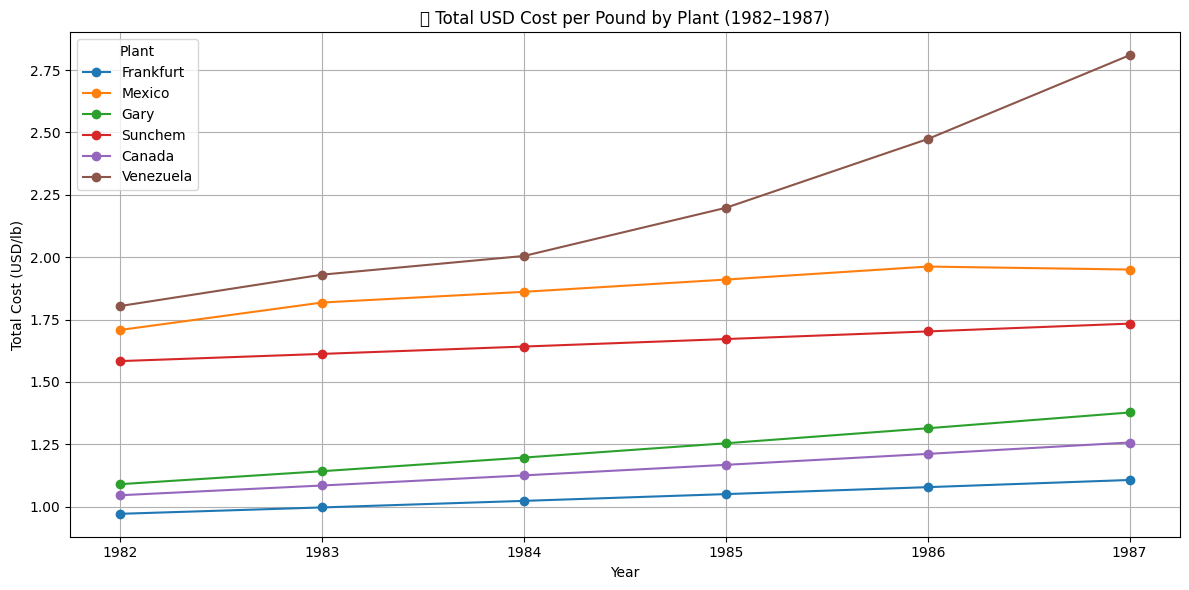

In [ ]:
import matplotlib.pyplot as plt

# Reconstructing USD total cost per lb per plant
plants = ["Frankfurt", "Mexico", "Gary", "Sunchem", "Canada", "Venezuela"]
years = list(range(1982, 1988))

# Input assumptions
base_local_cost = {"Frankfurt": 1.85, "Mexico": 97, "Gary": 1.04, "Sunchem": 320, "Canada": 1.20, "Venezuela": 4.8}
fx_adjustment = {
    "Frankfurt": [2.38]*6,
    "Mexico": [96.5, 105, 115, 125, 135, 150],
    "Gary": [1]*6,
    "Sunchem": [235]*6,
    "Canada": [1.23]*6,
    "Venezuela": [4.3, 5.0, 6.0, 6.8, 7.5, 8.2]
}
inflation = {"Frankfurt": 0.03, "Mexico": 0.20, "Gary": 0.05, "Sunchem": 0.02, "Canada": 0.04, "Venezuela": 0.25}
tariffs = {
    "Frankfurt": [0.095]*6,
    "Mexico": [0.60, 0.55, 0.45, 0.35, 0.25, 0.15],
    "Gary": [0]*6,
    "Sunchem": [0.06]*6,
    "Canada": [0]*6,
    "Venezuela": [0.50]*6
}
transport = {
    "Frankfurt": [0.12]*6,
    "Mexico": [0.10]*6,
    "Gary": [0.05]*6,
    "Sunchem": [0.14]*6,
    "Canada": [0.07]*6,
    "Venezuela": [0.13]*6
}

# Calculate total cost
usd_total_cost = {plant: [] for plant in plants}
for i, year in enumerate(years):
    for plant in plants:
        infl = (1 + inflation[plant]) ** i
        local = base_local_cost[plant] * infl
        fx = fx_adjustment[plant][i]
        base_usd = local / fx
        tariff = tariffs[plant][i] * base_usd
        trans = transport[plant][i]
        total = base_usd + tariff + trans
        usd_total_cost[plant].append(total)

# Plotting
plt.figure(figsize=(12, 6))
for plant in plants:
    plt.plot(years, usd_total_cost[plant], marker='o', label=plant)

plt.title("💰 Total USD Cost per Pound by Plant (1982–1987)")
plt.xlabel("Year")
plt.ylabel("Total Cost (USD/lb)")
plt.grid(True)
plt.legend(title="Plant")
plt.tight_layout()
plt.show()


Venezuela will spike fast due to inflation + tariffs

Mexico will start high but drop — becoming competitive by ~1986

Frankfurt stays steady, even with tariff

Gary remains relatively flat

Sunchem stays expensive due to high base cost + overseas transport